# part 1
### 1.1 Load the Libraries 

In [160]:
!pip install fake_useragent pandas matplotlib pillow wordcloud bs4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [114]:
import pandas as pd
import numpy as np
from fake_useragent import UserAgent
uae = UserAgent()
from bs4.element import Tag
import hashlib
import matplotlib.pyplot as plt
import json
from PIL import Image
import wordcloud
import re
# anlayze the words frequency
from collections import Counter

In [115]:
%matplotlib inline

###1.2 Movie list collection

In [116]:
from bs4 import BeautifulSoup
import requests 
import pandas as pd
# movie list page url template
url1 = 'https://www.imdb.com/search/title/?title_type=feature&keywords=based-on-short-story'
# movie url template
ut = 'https://www.imdb.com{}?ref_=adv_li_tt'
# 2 movie page, total 100 movies
pages = [url1, url1+'&start=51&ref_=adv_nxt']
# object stored the 100 movies
movies = {'title': [], 'url': [], 'year': []}

for page in pages:
    response = requests.get(page)
    soup = BeautifulSoup(response.text, 'html.parser')
    movies['url'].extend([ut.format(_['href']) for _ in soup.select(".lister-item-header a")])
    movies['title'].extend([_.string for _ in soup.select(".lister-item-header a")])
    movies['year'].extend([_.string[1:-1] for _ in soup.select("span.lister-item-year")])
    
# convert the dict to dataframe
movie_list = pd.DataFrame(movies, columns=movies.keys())
movie_list.to_csv('movie_list.csv', encoding='utf-8')

In [117]:
movie_list.head(6)

,title,url,year
0,The Shawshank Redemption,https://www.imdb.com/title/tt0111161/?ref_=adv...,1994
1,It's a Wonderful Life,https://www.imdb.com/title/tt0038650/?ref_=adv...,1946
2,Three Thousand Years of Longing,https://www.imdb.com/title/tt9198364/?ref_=adv...,2022
3,Eyes Wide Shut,https://www.imdb.com/title/tt0120663/?ref_=adv...,1999
4,The Black Phone,https://www.imdb.com/title/tt7144666/?ref_=adv...,2021
5,National Lampoon's Vacation,https://www.imdb.com/title/tt0085995/?ref_=adv...,1983


### 1.3 Print shape, head and tail of the dataframe

In [104]:
print(movie_list.shape)
print(movie_list.head())
print(movie_list.tail())

(100, 3)
                             title  \
0         The Shawshank Redemption   
1            It's a Wonderful Life   
2  Three Thousand Years of Longing   
3                   Eyes Wide Shut   
4                  The Black Phone   

                                                 url  year  
0  https://www.imdb.com/title/tt0111161/?ref_=adv...  1994  
1  https://www.imdb.com/title/tt0038650/?ref_=adv...  1946  
2  https://www.imdb.com/title/tt9198364/?ref_=adv...  2022  
3  https://www.imdb.com/title/tt0120663/?ref_=adv...  1999  
4  https://www.imdb.com/title/tt7144666/?ref_=adv...  2021  
                      title  \
95          Babette's Feast   
96             Bubba Ho-Tep   
97       Stonehearst Asylum   
98  Coming Home in the Dark   
99              Creepshow 2   

                                                  url  year  
95  https://www.imdb.com/title/tt0092603/?ref_=adv...  1987  
96  https://www.imdb.com/title/tt0281686/?ref_=adv...  2002  
97  https://www.imdb.co

###1.4 Save the dataframe to a CSV file 

In [118]:
movie_list.to_csv('movie_list.csv', index=False)

# part 2
###2.1load the movie_list.csv

In [119]:
movie_list = pd.read_csv('movie_list.csv')
movie_list.head()

,title,url,year
0,The Shawshank Redemption,https://www.imdb.com/title/tt0111161/?ref_=adv...,1994
1,It's a Wonderful Life,https://www.imdb.com/title/tt0038650/?ref_=adv...,1946
2,Three Thousand Years of Longing,https://www.imdb.com/title/tt9198364/?ref_=adv...,2022
3,Eyes Wide Shut,https://www.imdb.com/title/tt0120663/?ref_=adv...,1999
4,The Black Phone,https://www.imdb.com/title/tt7144666/?ref_=adv...,2021


### 2.2 
 We can get the movie information, including url, title, year, etc., and we can save and process the dataframe data

## 2.3 Scrape the movies information

### 2.3.1 Scrape basic information (8')
Please scrape the following information for each movie in the list:
- Title
- IMDb rating
- Popularity score
- Genres
- Release year
- Duration
- Storyline
- Box office

### 2.3.2 Scrape additional information (3')
Scrape additional details, technical specs, etc. You may need them for your analysis.

In [120]:
# 查找单个键
def find(target, dictData, notFound):
    queue = [dictData]
    s = ''
    while len(queue) > 0:
        data = queue.pop()
        for key, value in data.items():
            if key.lower() == target: 
                return value
            elif type(value) == dict: queue.append(value)
    return notFound

# 有多个同名键
def findAll(target, dictData, notFound=[]):
    queue = [dictData]
    result = []
    while len(queue) > 0:
        data = queue.pop()
        for key, value in data.items():
            if key.lower() == target: result.append(value)
            elif type(value) == dict: queue.append(value)
    if not result: result = notFound
    return result

# 有多个同名键值
def findValueAll(target, dictData, notFound=[]):
    queue = [dictData]
    result = []
    while len(queue) > 0:
        data = queue.pop()
        for key, value in data.items():
            if value == target: result.append(data)
            elif type(value) == dict: queue.append(value)
    if not result: result = notFound
    return result

In [130]:
# imdb_movie_columns = ['Title','IMDb rating','Popularity score','Genres','Release year','Duration','Storyline','Box office', 'votes']
imdb_movie_columns = ['title','rating','score','genres','year','duration','storyLine','boxOffice', 'votes']

imdb_movie_columns

['title',
 'rating',
 'score',
 'genres',
 'year',
 'duration',
 'storyLine',
 'boxOffice',
 'votes']

In [110]:
imdb_movies_d = {k: [] for k in imdb_movie_columns}


for i, movie in movie_list.iterrows():
    item = []
    #print(movie.title)
    #raise Exception("debug")
    res = requests.get(movie.url, headers={'User-Agent': uae.chrome})
    soup = BeautifulSoup(res.text, 'html.parser')
    
    script1 = soup.find(type='application/ld+json').string
    j_script1 = json.loads(script1)
    script2 = soup.find(id="__NEXT_DATA__").string    
    j_script2 = json.loads(script2)
    
    # Title
    item.append(movie.title)
    # rating
    item.append(j_script2['props']['pageProps']['aboveTheFoldData']['ratingsSummary']['aggregateRating'])
    # popularity score
    item.append(j_script2['props']['pageProps']['aboveTheFoldData']['meterRanking']['currentRank'])
    # genres
    item.append([_['text'] for _ in j_script2['props']['pageProps']['aboveTheFoldData']['genres']['genres']])
    # release year
    item.append(movie.year)
    # duration
    item.append(j_script1['duration'])
    # story line
    item.append(j_script1['description'])
    # box office gross
    # boxoffice = findValueAll('BoxOfficeGross', data2)]
    try:
        item.append(find('worldwidegross', j_script2)['total']['amount'])
    except:
        item.append('')
    # aspect ratio technical spec
    try:
        item.append(find('aspectratios', j_script2['props'])['items'][0]['aspectRatio'].replace(' ', ''))
    except:
        item.append('')
    with open('imdb_movies_buff.txt', 'a+', encoding='utf-8') as f:
        line = '|'.join([str(_) for _ in item]) + '\n'
        f.write(line)
    print(f'scrape movie count: {i}, movie url: {movie.url}')

scrape movie count: 0, movie url: https://www.imdb.com/title/tt0111161/?ref_=adv_li_tt
scrape movie count: 1, movie url: https://www.imdb.com/title/tt0038650/?ref_=adv_li_tt
scrape movie count: 2, movie url: https://www.imdb.com/title/tt9198364/?ref_=adv_li_tt
scrape movie count: 3, movie url: https://www.imdb.com/title/tt0120663/?ref_=adv_li_tt
scrape movie count: 4, movie url: https://www.imdb.com/title/tt7144666/?ref_=adv_li_tt
scrape movie count: 5, movie url: https://www.imdb.com/title/tt0085995/?ref_=adv_li_tt
scrape movie count: 6, movie url: https://www.imdb.com/title/tt9783600/?ref_=adv_li_tt
scrape movie count: 7, movie url: https://www.imdb.com/title/tt0388795/?ref_=adv_li_tt
scrape movie count: 8, movie url: https://www.imdb.com/title/tt0062622/?ref_=adv_li_tt
scrape movie count: 9, movie url: https://www.imdb.com/title/tt2543164/?ref_=adv_li_tt
scrape movie count: 10, movie url: https://www.imdb.com/title/tt0209144/?ref_=adv_li_tt
scrape movie count: 11, movie url: https:/

TypeError: ignored

In [121]:
# use the disk io instead of the network io, reduce the memory ocuupation cost
imdb_movies = pd.read_csv('imdb_movies_buff.txt', sep='|', header=None)
imdb_movies.columns = imdb_movie_columns
imdb_movies.head()

,title,rating,score,genres,year,duration,storyLine,boxOffice,aspectRatio
0,The Shawshank Redemption,9.3,97,['Drama'],1994,PT2H22M,Two imprisoned men bond over a number of years...,28884504.0,1.85:1
1,It's a Wonderful Life,8.6,134,"['Drama', 'Family', 'Fantasy', 'Romance']",1946,PT2H10M,An angel is sent from Heaven to help a despera...,6184298.0,1.37:1
2,Three Thousand Years of Longing,6.7,202,"['Drama', 'Fantasy', 'Romance']",2022,PT1H48M,"A lonely scholar, on a trip to Istanbul, disco...",19223063.0,2.39:1
3,Eyes Wide Shut,7.5,206,"['Drama', 'Mystery', 'Thriller']",1999,PT2H39M,"A Manhattan doctor embarks on a bizarre, night...",162242684.0,NaN
4,The Black Phone,6.9,207,"['Horror', 'Thriller']",2021,PT1H43M,After being abducted by a child killer and loc...,161204742.0,2.39:1


In [123]:
imdb_movies.to_csv('imdb_movies.csv')

## 2.3.3 Scrape cast information (3')

In [124]:
cast_ut = 'https://www.imdb.com/title/{}/fullcredits/?ref_=tt_cl_sm'
columns = ['title', 'directors', 'cast', 'role']

def deal_one_multiple(selector, target):
    '''solved one corresponds to several'''
    data = []
    for _ in soup.select(selector):
        nodes = _.select(target)
        if len(nodes)==1:
            each = nodes[0].string.strip()
        else:
            each = [node.string.strip() for node in nodes]
        data.append(each)
    return data

def write_batch_to_file(title, directors, casts, roles):
    with open('cast_buff.txt', 'a+', encoding='utf-8') as f:
        for i, cast in enumerate(casts):
            line = '|'.join([title, str(directors), cast, str(roles[i])]) + '\n'
            f.write(line)
            

for i, movie in movie_list[['title', 'url']].iterrows():
    mid = re.search('(tt\d+)', movie.url).group(1)
    response = requests.get(cast_ut.format(mid), headers={'User-Agent': uae.chrome})
    soup = BeautifulSoup(response.text, 'html.parser')
    
    casts = [_.find_next_sibling().a.string.strip() for _ in soup.select('table.cast_list tr td.primary_photo')]

    # one cast to multiple roles
    roles = deal_one_multiple('table.cast_list tr td.character', 'a')

    # l1 = len(casts)
    # l2 = len(imdb_cast_d['role'])
    # titles.extend([movie.title for _ in range(l1)])
    directors = deal_one_multiple('#fullcredits_content > table:nth-of-type(1) > tbody > tr > td.name', 'a')
    
    # write file, reduce the program executation memory
    write_batch_to_file(movie.title, directors, casts, roles)

    print(f'scrape movie count: {i}, movie url: {cast_ut.format(mid)}')

scrape movie count: 0, movie url: https://www.imdb.com/title/tt0111161/fullcredits/?ref_=tt_cl_sm
scrape movie count: 1, movie url: https://www.imdb.com/title/tt0038650/fullcredits/?ref_=tt_cl_sm
scrape movie count: 2, movie url: https://www.imdb.com/title/tt9198364/fullcredits/?ref_=tt_cl_sm
scrape movie count: 3, movie url: https://www.imdb.com/title/tt0120663/fullcredits/?ref_=tt_cl_sm
scrape movie count: 4, movie url: https://www.imdb.com/title/tt7144666/fullcredits/?ref_=tt_cl_sm
scrape movie count: 5, movie url: https://www.imdb.com/title/tt0085995/fullcredits/?ref_=tt_cl_sm
scrape movie count: 6, movie url: https://www.imdb.com/title/tt9783600/fullcredits/?ref_=tt_cl_sm
scrape movie count: 7, movie url: https://www.imdb.com/title/tt0388795/fullcredits/?ref_=tt_cl_sm
scrape movie count: 8, movie url: https://www.imdb.com/title/tt0062622/fullcredits/?ref_=tt_cl_sm
scrape movie count: 9, movie url: https://www.imdb.com/title/tt2543164/fullcredits/?ref_=tt_cl_sm
scrape movie count: 

In [125]:
imdb_cast = pd.read_csv('cast_buff.txt', sep='|', header=None)
imdb_cast.columns = ['title', 'directors', 'cast', 'role']
# imdb_cast.head()
imdb_cast.shape

(5348, 4)

In [126]:
imdb_cast.to_csv('imdb_cast.csv')

## 2.3.4 Scrape connections information (3')

In [131]:
def get_elements(elem):
    elems = []
    if not elem: return elems
    elem = elem.find_next_sibling()
    while elem.attrs.get('class', []):
        # found out the key class value soda
        if 'soda' in elem.attrs.get('class', []): elems.append(elem)
        # if no other sibling elements any more, it will return None 
        elem = elem.find_next_sibling()
        if elem == None: break
    return [_.a.string for _ in elems]

In [132]:
links = []

lt = 'https://www.imdb.com/title/{}/movieconnections/?ref_=tt_trv_cnn'
for i, movie in movie_list[['title', 'url']].iterrows():
    title = movie.title
    # movie unique id
    mid = re.search('(tt\d+)', movie.url).group(1)
    response = requests.get(lt.format(mid), headers={'User-Agent': uae.chrome})
    soup = BeautifulSoup(response.text, 'html.parser')
    
    reference_elem = soup.find('a', attrs={'id': 'references'})
    referenced_in_elem = soup.find('a', attrs={'id': 'referenced_in'})
    # get all the references (start node)
    references = get_elements(reference_elem)
    # get all the referenced_in (end node)
    referenceds_in = get_elements(referenced_in_elem)
    # make edge list, (start node -> end node)
    for _ in references: links.append([_, title])
    for _ in referenceds_in: links.append([title, _])
    # here we won't add the the pointer from references to referenceds_in, it will be redundant

In [133]:
imdb_links = pd.DataFrame(links, columns=['start', 'end'])
imdb_links.head()

,start,end
0,The Grand Illusion,The Shawshank Redemption
1,Brute Force,The Shawshank Redemption
2,Harvey,The Shawshank Redemption
3,The Seven Year Itch,The Shawshank Redemption
4,A Man Escaped,The Shawshank Redemption


In [134]:
imdb_links.to_csv('imdb_links.csv')

## 2.4 Check the columns of all the dataframes. (1')

In [135]:
print('movie_list:\n\t', movie_list.head())
print('imdb_movies:\n\t', imdb_movies.head())
print('imdb_cast:\n\t', imdb_cast.head())
print('imdb_links:\n\t', imdb_links.head())

movie_list:
	                              title  \
0         The Shawshank Redemption   
1            It's a Wonderful Life   
2  Three Thousand Years of Longing   
3                   Eyes Wide Shut   
4                  The Black Phone   

                                                 url  year  
0  https://www.imdb.com/title/tt0111161/?ref_=adv...  1994  
1  https://www.imdb.com/title/tt0038650/?ref_=adv...  1946  
2  https://www.imdb.com/title/tt9198364/?ref_=adv...  2022  
3  https://www.imdb.com/title/tt0120663/?ref_=adv...  1999  
4  https://www.imdb.com/title/tt7144666/?ref_=adv...  2021  
imdb_movies:
	                              title  rating  score  \
0         The Shawshank Redemption     9.3     97   
1            It's a Wonderful Life     8.6    134   
2  Three Thousand Years of Longing     6.7    202   
3                   Eyes Wide Shut     7.5    206   
4                  The Black Phone     6.9    207   

                                      genres  year durati

I found that these data are highly correlated, for example, I can go to other tables to get the director, actors, reference works and other information of the movie through a movie name

## 2.5 Check the index. (2')

> answer

we can choose a column as the index, such as the movie name(title). The reason is simple, because it's unique.
> action: 

- 1. we need hash the movie name/title string. it will let the movie name/title indexed looks like pretty.

- 2. we will add the above the movie hash name/title into the dataframe as the index. 

In [136]:
# for test, we need backup the origin dataframe, avoid to pollute origin data
test = movie_list

def md5(raw: str):
    m = hashlib.md5()
    m.update(raw.encode())
    return m.hexdigest()

# hash the movie name / tile
indexed = [md5(_) for _ in movie_list.title]
# add the indexed column as the index of the dataframe
test.insert(0, 'indexed', indexed, allow_duplicates=False)
test.head()

,indexed,title,url,year
0,c121b9f541e85a37659a3bf0d18e5ad8,The Shawshank Redemption,https://www.imdb.com/title/tt0111161/?ref_=adv...,1994
1,b2efb7dbe92324d458027d07fc8e3c79,It's a Wonderful Life,https://www.imdb.com/title/tt0038650/?ref_=adv...,1946
2,ff687639ee17a6f33ce35990fbbdf6ab,Three Thousand Years of Longing,https://www.imdb.com/title/tt9198364/?ref_=adv...,2022
3,148287006ebbaabb17761ceaa6e13435,Eyes Wide Shut,https://www.imdb.com/title/tt0120663/?ref_=adv...,1999
4,bd477b7ec657ef67d9d7f512bbb90261,The Black Phone,https://www.imdb.com/title/tt7144666/?ref_=adv...,2021


In [137]:
test.set_index('indexed', append=True)
test.head()

,indexed,title,url,year
0,c121b9f541e85a37659a3bf0d18e5ad8,The Shawshank Redemption,https://www.imdb.com/title/tt0111161/?ref_=adv...,1994
1,b2efb7dbe92324d458027d07fc8e3c79,It's a Wonderful Life,https://www.imdb.com/title/tt0038650/?ref_=adv...,1946
2,ff687639ee17a6f33ce35990fbbdf6ab,Three Thousand Years of Longing,https://www.imdb.com/title/tt9198364/?ref_=adv...,2022
3,148287006ebbaabb17761ceaa6e13435,Eyes Wide Shut,https://www.imdb.com/title/tt0120663/?ref_=adv...,1999
4,bd477b7ec657ef67d9d7f512bbb90261,The Black Phone,https://www.imdb.com/title/tt7144666/?ref_=adv...,2021


## 2.6 Extract descriptive statistics for numerical variables in all the dataframes. (1')

Give a brief description of your findings (within 50 words)

1. The most casts are fresh man
2. The most movie role name is unique
3. According to the edge list(starting node -> ending node), we find out the unique start nodes are a few

In [138]:
# movie_list.describe()
# imdb_movies.describe()
# imdb_cast.describe()
imdb_links.describe()

,start,end
count,10338,10336
unique,529,8516
top,2001: A Space Odyssey,Minority Report
freq,1239,73


## 2.7 Get information from all the dataframes (1')

Give a brief description (within 50 words)

正态分布等角度分析

In [139]:
movie_list.info()
# imdb_movies.info()
# imdb_cast.info()
# imdb_links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   indexed  100 non-null    object
 1   title    100 non-null    object
 2   url      100 non-null    object
 3   year     100 non-null    object
dtypes: object(4)
memory usage: 3.2+ KB


# Part 3: Data cleaning and transformation [10%]

# 3.1 Change the box office information to numerical values (3')

Transform to integer values

In [140]:
movies = imdb_movies

# normalizer = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
# movies.boxOffice.apply(normalizer)
movies['boxOffice'] = pd.to_numeric(movies['boxOffice'], errors='coerce').fillna(0).astype(int)
movies.boxOffice

0       28884504
1        6184298
2       19223063
3      162242684
4      161204742
         ...    
139            0
140            0
141            0
142            0
143            0
Name: boxOffice, Length: 144, dtype: int64

## 3.2 Add a new column named `rating_category` (5')

The values of `rating_category` should be generated from the IMDB ratings as follows:
   
- Good (7 to 10)
- Average (5 to 7),
- Bad (0 to 5)

In [141]:
judge = lambda x: 'Good' if x>7 else 'Average' if x>5 else 'Bad'
movies['rating_category'] = movies.rating.apply(judge)

movies['rating_category'].value_counts()

Good       80
Average    64
Name: rating_category, dtype: int64

## 3.3 Clean NULL values (2')

Change `NA` values in the columns with missing values to `Not Available` in all the dataframes

In [142]:
movie_list = movie_list.dropna(inplace=False)

imdb_movies = imdb_movies.dropna(inplace=False)

imdb_cast = imdb_cast.dropna(inplace=False)

imdb_links = imdb_links.dropna(inplace=False)

# Part 4: Querying the dataframes and visualizing data [42%]

## 4.1 Find the top 10 movies with the shortest duration (in minutes).

In [143]:
# PT time to utc
def pt_2_utc(x):
    h, m = re.search('PT(\d*)H(\d*)M', x).groups()
    return int(h) * 60 + int(m)
    
movies = imdb_movies

movies['duration'] = movies.duration.apply(lambda x: pt_2_utc(x))
movies.duration.sort_values(ascending=True).iloc[:10]

<ipython-input-143-bb86bb861a39>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['duration'] = movies.duration.apply(lambda x: pt_2_utc(x))


51    64
26    83
62    84
71    87
66    88
56    92
30    93
67    93
23    94
69    95
Name: duration, dtype: int64

## 4.2 Find the movies that have been released before year 2000. (4')

In [144]:
# movies.year.dtype -> int64

movies.dropna(inplace=True)

movies.year = pd.to_numeric(movies['year'], errors='coerce').fillna(0).astype(int)

result = movies[movies.year<2000]
# you maybe see the release year is 0, dont worry it only show that we didn't scrape the digit
result[['title', 'year']].head()

,title,year
0,The Shawshank Redemption,1994
1,It's a Wonderful Life,1946
5,National Lampoon's Vacation,1983
8,2001: A Space Odyssey,1968
9,Arrival,0


## 4.3 Find the top 10 actors appearing in multiple movies. (4')

In [145]:
# imdb_cast.columns

actors = imdb_cast.cast
# len(actors)
actors.value_counts().sort_values(ascending=True).iloc[:10]

Joey Ansah           1
Richard Doone        1
Samantha Goldberg    1
Shane Grove          1
Rita Hayworth        1
David Hecht          1
Alonzo F. Jones      1
Dennis Baker         1
George Noisom        1
Anton Northpole      1
Name: cast, dtype: int64

## 4.3 Use scatter plot to visualize the relationship between duration and popularity score. (5')

State your findings from the scatter plot (within 50 words).

- More short duration movies
- Shorter movies generally receive higher ratings

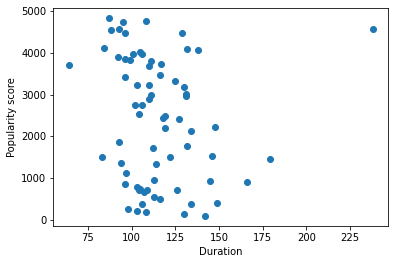

In [146]:
# graph scatter
durations = movies.duration
popularity_scores = movies.score

plt.scatter(durations, popularity_scores)
# set axis
plt.xlabel('Duration')
plt.ylabel('Popularity score')
# show
plt.show()

### 4.3a Generate dummies from the IMDB Categories Good, Average, Bad movies (2’)

In [147]:
judge = lambda x: 'Good' if x>7 else 'Average' if x>5 else 'Bad'

movies['rating_category'] = movies.rating.apply(judge)
dummies = imdb_movies[(imdb_movies.rating_category=='Average')][['duration', 'score']]
dummies

,duration,score
2,108,202
4,103,207
6,106,375
11,107,681
14,104,725
31,134,2129
32,119,2191
34,127,2414
35,118,2447
37,104,2534


In [148]:
movies.columns

dummies.values[0]

array([108, 202])

In [149]:
judge = lambda x: 'Good' if x>7 else 'Average' if x>5 else 'Bad'

movies['rating_category'] = movies.rating.apply(judge)
dummies = imdb_movies[(imdb_movies.rating_category=='Good')][['duration', 'score']]
dummies

,duration,score
0,142,97
1,130,134
5,98,261
7,134,393
8,149,411
9,116,514
10,113,539
12,109,706
13,126,720
15,105,750


In [150]:
movies.columns

dummies.values[0]

array([142,  97])

In [151]:
judge = lambda x: 'Good' if x>7 else 'Average' if x>5 else 'Bad'

movies['rating_category'] = movies.rating.apply(judge)
dummies = imdb_movies[(imdb_movies.rating_category=='Bad')][['duration', 'score']]
dummies

,duration,score


### 4.3b Use the dummies features to assign a color to the data points in the scatter plot (2’)

State your findings from the scatter plot (within 50 words).

就是这里需要将 dummies 的点用颜色表示出来，因为dummies可以作为分组的field切割出duration和score
也可以不用颜色表示

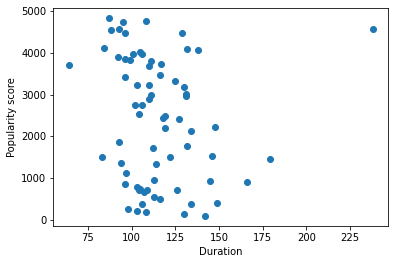

In [152]:
movies = imdb_movies
# 绘制散点图
durations = movies.duration
popularity_scores = movies.score

plt.scatter(durations, popularity_scores)
# 设置 x 轴和 y 轴的标签
plt.xlabel('Duration')
plt.ylabel('Popularity score')
# 显示图表
plt.show()

## 4.4. Show the trend of average gross income worldwide per year, using a line chart. (4')

State your findings from the line chart (within 50 words)

`The movie box office began to heat up in 2019, until it reached its peak in 2020, and then slowly cooled down`

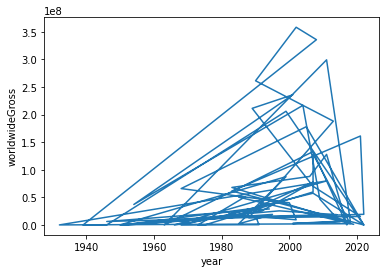

In [153]:
x = movies[movies.year > 0].year
y = movies[movies.year > 0].boxOffice
plt.plot(x, y)
plt.xlabel('year')
plt.ylabel('worldwideGross')
plt.show()

## 4.5 Visualize the distribution of box office of all movies, using a histogram. (5')

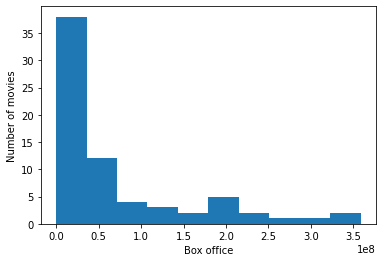

In [154]:
# graph histogram
plt.hist(movies.boxOffice)
# set x axis and y axis label
plt.xlabel('Box office')
plt.ylabel('Number of movies')
# show
plt.show()


## 4.6 Create a boxplot of the duration of all movies given their rating category. (5')

State your findings from the wordcloud (within 50 words).

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


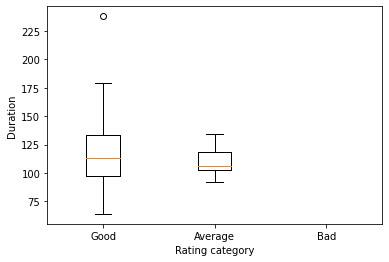

In [155]:
# graph the boxplot
# plt.boxplot(movies[movies.rating_category=='Good'].duration.values)
# plt.boxplot(movies[movies.rating_category=='Average'].duration.values)
# plt.boxplot(movies[movies.rating_category=='Bad'].duration.values)

x1 = movies[movies.rating_category=='Good'].duration.values
x2 = movies[movies.rating_category=='Average'].duration.values
x3 = movies[movies.rating_category=='Bad'].duration.values
plt.boxplot([x1, x2, x3], labels=['Good', 'Average', 'Bad'])

# set axis, yaxis
plt.xlabel('Rating category')
plt.ylabel('Duration')
# show
plt.show()
# len(movies.duration.values)
# len(movies.rating_category.values)

## 4.7 Create a word cloud visualization of the storyline of all movies. (5')

State your findings from the wordcloud (within 50 words).

`Themes are family, relationship, loneliness`

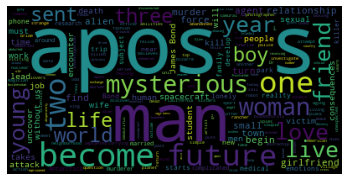

In [156]:
# 创建词云
import wordcloud

wc = wordcloud.WordCloud()
wc.generate(' '.join(list(movies.storyLine.values)))

# 显示词云
plt.imshow(wc)
plt.axis("off")
plt.show()

### 4.7a Analyse the frequency of the words then set a threshold for visualization (1')

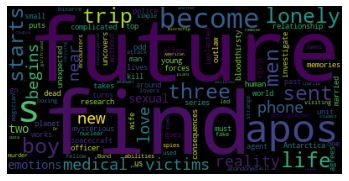

In [157]:
# anlayze the words frequency
from collections import Counter

c = Counter()
for storyline in movies.storyLine.values:
    words = storyline.split(' ')
    for word in words:
        c[word] += 1

# 设置阈值
threshold = 2

# 筛选频率大于等于阈值的单词
common_words = [word for word, count in c.items() if count >= threshold]
wc.generate(' '.join(common_words))

# 显示词云
plt.imshow(wc)
plt.axis("off")
plt.show()

### 4.7b Select a mask for the word cloud (1')

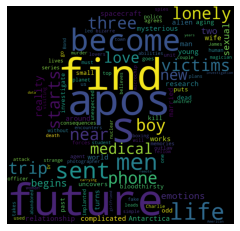

In [158]:
# 创建词云
from PIL import Image

mask = np.array(Image.open('./mask人像图片.png'))
wc = wordcloud.WordCloud(mask=mask)
wc.generate(' '.join(common_words))

# 显示词云
plt.imshow(wc)
plt.axis("off")
plt.show()

# 结束